## Dataset

In [1]:
import os
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import dask
import torch
from dataset import *
from torch.utils.data import DataLoader

folder_path =  '/home/data2/pengguohang/My_Ocean/challenge'
label_path = '/home/data2/pengguohang/My_Ocean/CMEMS/armor_montly_1993_2019/armor_1993_2019.nc'
reference_file = '/home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc'


In [2]:
# 分割train val test

train_data = STDataset(
                 region_name = 'Gulf',
                 folder_path=folder_path,
                 reference_file = reference_file, 
                 label_path = label_path,
                 lat_min = 23,
                 lat_max = 50, 
                 lon_min = -80,
                 lon_max = -30,
                 key = 'so'
                 )
train_size = int(len(train_data) * 0.8)
validate_size = int(len(train_data) * 0.1)
test_size = len(train_data) - validate_size - train_size
train_dataset, validate_dataset, test_dataset = torch.utils.data.random_split(train_data, [train_size, validate_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
validate_loader = DataLoader(validate_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(len(train_loader))
print(len(validate_loader))
print(len(test_loader))

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc


Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of region: (8, 109, 108, 200)


/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


87
10
12


In [3]:
data = next(iter(train_loader))
print(len(data))
for data in train_loader:
    input = data[0]
    label = data[1]
    lat = data[2]
    lon = data[3]
    depth = data[4]
    print('input, label:', input.shape, label.shape)
    break


5
input, label: torch.Size([1, 8, 108, 200]) torch.Size([1, 36, 108, 200])


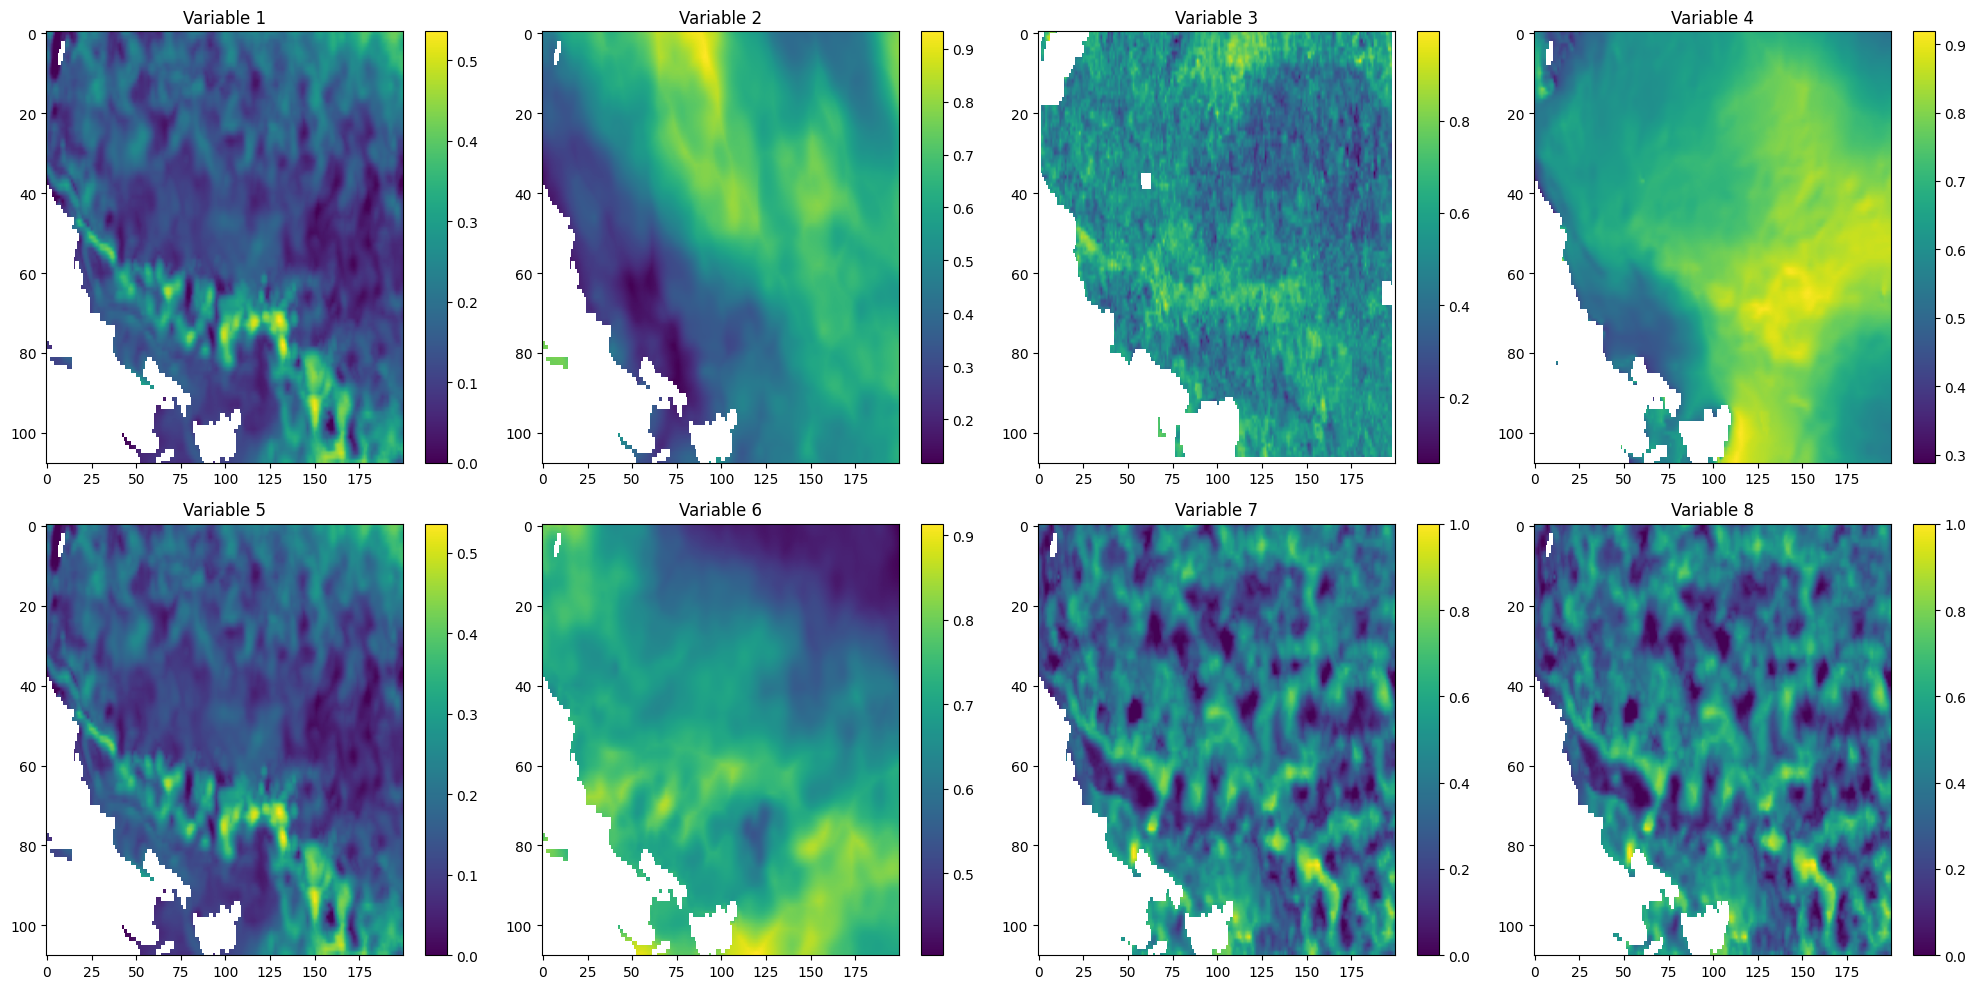

In [4]:
# 查看我的输入

def plot_ocean_data(data, i):
    data = data[i, ...]
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # 绘制每个变量
    for i in range(8):
        # print(data[i].shape)
        ax = axes[i // 4, i % 4]
        im = ax.imshow(data[i], aspect='auto')
        ax.set_title(f'Variable {i+1}')
        fig.colorbar(im, ax=ax)
        
        # 显示图像
    plt.tight_layout()
    plt.show()

plot_ocean_data(input, 0)

第4层全为nan
第6层全为nan
第20层全为nan


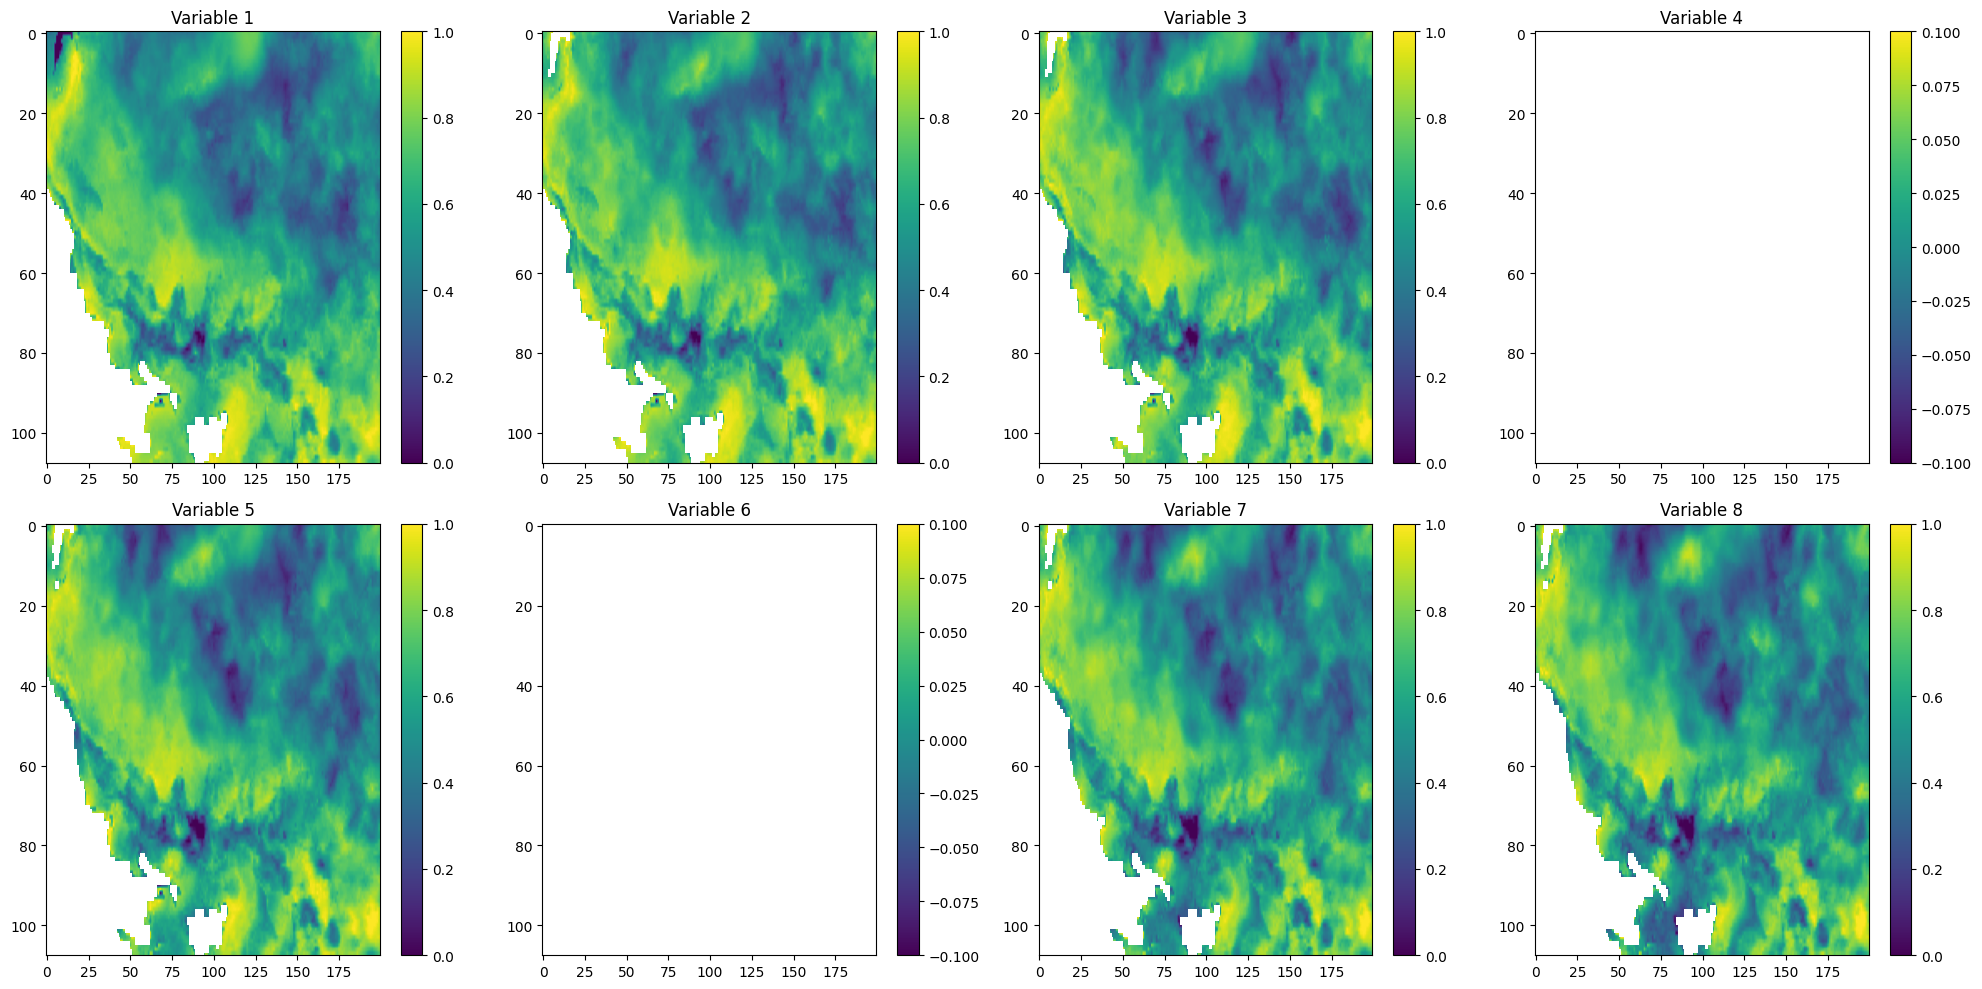

In [17]:
# 3 绘制前八个层
for i in range(label.shape[1]):
    data = label[0, i, ...]
    nan = np.isnan(data).reshape(-1)
    judge = all(item == 1 for item in nan)
    if judge:
        print(f'第{i+1}层全为nan')


plot_ocean_data(label, 0)

## Model

In [5]:
from model import FFNN
from torch import nn
from tqdm import tqdm
from torch import optim

# 定义设备
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
activ =  'Sigmoid'
opt='Adam'
pat=30
n_epochs = 10
val_split=.15
dropout_fraction=.2
n_units1 =1000
n_units2= 1000


In [9]:
input_dim = int(input.shape[1]) * int(input.shape[2]) * int(input.shape[3])  # depth * lat * lon
output_dim = 3 * int(label.shape[2]) * int(label.shape[3])  # depth * lat * lon

# print(type(input_dim), output_dim)

model = FFNN(input_dim, output_dim, n_units1, n_units2, dropout_fraction, activ).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 假设使用SGD优化器，您可以根据需要更改

train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, targets, _, _, _ in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.shape[0]
        inputs = inputs.reshape(batch_size, -1)
        targets = targets[:, 0:3, ...].reshape(batch_size, -1)

        optimizer.zero_grad()
        # print(inputs.shape)
        # print('output, target:', outputs.shape, targets.shape)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, _, _, _ in validate_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.shape[0]
            inputs = inputs.reshape(batch_size, -1)
            targets = targets[:, 0:3, ...].reshape(batch_size, -1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss = val_loss / len(validate_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
    if epoch > pat and all(val_loss >= val_losses[-pat:]):
        print('Early stopping triggered')
        break

# 保存模型
# torch.save(model.state_dict(), f'./result/WOC_FFNN_sig_{n_units1}_{n_units2}_MODEL.pth')
# print("Saved model to disk")
# Epoch 10/10, Training Loss: 0.0173, Validation Loss: 0.0170

 10%|█         | 1/10 [00:00<00:08,  1.04it/s]

Epoch 1/10, Training Loss: nan, Validation Loss: nan


 20%|██        | 2/10 [00:01<00:07,  1.04it/s]

Epoch 2/10, Training Loss: nan, Validation Loss: nan


 30%|███       | 3/10 [00:02<00:06,  1.04it/s]

Epoch 3/10, Training Loss: nan, Validation Loss: nan


 40%|████      | 4/10 [00:03<00:05,  1.04it/s]

Epoch 4/10, Training Loss: nan, Validation Loss: nan


 50%|█████     | 5/10 [00:04<00:04,  1.04it/s]

Epoch 5/10, Training Loss: nan, Validation Loss: nan


 60%|██████    | 6/10 [00:05<00:03,  1.04it/s]

Epoch 6/10, Training Loss: nan, Validation Loss: nan


 70%|███████   | 7/10 [00:06<00:02,  1.04it/s]

Epoch 7/10, Training Loss: nan, Validation Loss: nan


 80%|████████  | 8/10 [00:07<00:01,  1.04it/s]

Epoch 8/10, Training Loss: nan, Validation Loss: nan


 90%|█████████ | 9/10 [00:08<00:00,  1.04it/s]

Epoch 9/10, Training Loss: nan, Validation Loss: nan


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

Epoch 10/10, Training Loss: nan, Validation Loss: nan
